## Amazon Product Review

### Libraries

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

### Dataset

In [3]:
df = pd.read_csv("Amazon.csv")
df.head(3)

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams


In [4]:
df.shape

(1597, 27)

In [5]:
def df_info(df):
    print("Shape of dataframe: ", df.shape)
    print("Nan values: ", df.isna().sum().sum())
    print("Duplicate values: ", df.duplicated(keep= False).sum())
df_info(df)

Shape of dataframe:  (1597, 27)
Nan values:  12871
Duplicate values:  0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

In [7]:
for col in df:
    percentage = df[col].isna().sum() / df.shape[0] *100
    print(f'{col} : {percentage}')

id : 0.0
asins : 0.0
brand : 0.0
categories : 0.0
colors : 51.534126487163434
dateAdded : 0.0
dateUpdated : 0.0
dimension : 64.6211646837821
ean : 43.76956793988729
keys : 0.0
manufacturer : 39.5742016280526
manufacturerNumber : 43.51909830933
name : 0.0
prices : 0.0
reviews.date : 23.794614902943017
reviews.doRecommend : 66.2492172824045
reviews.numHelpful : 43.64433312460864
reviews.rating : 26.29931120851597
reviews.sourceURLs : 0.0
reviews.text : 0.0
reviews.title : 1.0644959298685035
reviews.userCity : 100.0
reviews.userProvince : 100.0
reviews.username : 1.0644959298685035
sizes : 100.0
upc : 43.76956793988729
weight : 57.04445835942392


In [8]:
df.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight'],
      dtype='object')

### Preprocessing

In [9]:
df.drop(columns=['sizes','upc', 'weight','reviews.userCity', 'dimension', "keys", "manufacturer", "ean","manufacturerNumber",
                 "brand", "colors", "reviews.date","reviews.sourceURLs", "dateAdded", "dateUpdated", "reviews.userProvince",
                 "reviews.doRecommend", "reviews.numHelpful"], inplace=True, errors="ignore")

In [10]:
df["prices"].iloc[10]


'[{"amountMax":139.99,"amountMin":139.99,"currency":"USD","dateAdded":"2017-07-18T23:52:58Z","dateSeen":["2017-07-15T18:10:23.807Z","2016-03-16T00:00:00Z"],"isSale":"false","merchant":"Amazon.com","shipping":"FREE Shipping.","sourceURLs":["https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7","http://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built-/dp/B00QJDU3KY"]},{"amountMax":119.99,"amountMin":119.99,"condition":"new","currency":"EUR","dateAdded":"2016-03-08T20:21:53Z","dateSeen":["2016-01-29T00:00:00Z"],"isSale":"false","merchant":"Amazon EU Sarl","shipping":"free","sourceURLs":["http://www.amazon.co.uk/Kindle-Paperwhite-Resolution-Display-Built-/dp/B00QJDU3KY"]},{"amountMax":139.99,"amountMin":139.99,"condition":"new","currency":"CAD","dateAdded":"2016-03-08T20:21:53Z","dateSeen":["2016-01-11T00:00:00Z"],"isSale":"false","merchant":"Amazon","shipp

In [11]:
df["categories"].iloc[0]

'Amazon Devices,mazon.co.uk'

In [12]:
df["categories"].iloc[500]

'Amazon Devices,Kindle Store'

In [13]:
df.rename(columns={
    "reviews.username": "user_id",
    "asins": "product_id",
    "reviews.rating": "rating"
}, inplace=True)

In [14]:
for col in df:
    percentage = df[col].isna().sum() / df.shape[0] *100
    print(f'{col} : {percentage}')

id : 0.0
product_id : 0.0
categories : 0.0
name : 0.0
prices : 0.0
rating : 26.29931120851597
reviews.text : 0.0
reviews.title : 1.0644959298685035
user_id : 1.0644959298685035


In [15]:
df.dropna(subset=["reviews.title", "user_id"], inplace=True)

In [16]:
rating_mean = (df["rating"].mean())

In [17]:
df["rating"] = df["rating"].fillna(rating_mean)

In [18]:
for col in df:
    percentage = df[col].isna().sum() / df.shape[0] *100
    print(f'{col} : {percentage}')

id : 0.0
product_id : 0.0
categories : 0.0
name : 0.0
prices : 0.0
rating : 0.0
reviews.text : 0.0
reviews.title : 0.0
user_id : 0.0


In [19]:
import json

df["price"] = df["prices"].apply(lambda x: json.loads(x)[0]["amountMin"])

In [20]:
df.drop(columns=["prices"], inplace=True)

In [21]:
df.tail()

,id,product_id,categories,name,rating,reviews.text,reviews.title,user_id,price
1592,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"Amazon Devices & Accessories,Amazon Device Acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,3.0,This is not the same remote that I got for my ...,I would be disappointed with myself if i produ...,GregAmandawith4,29.99
1593,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"Amazon Devices & Accessories,Amazon Device Acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,1.0,I have had to change the batteries in this rem...,Battery draining remote!!!!,Amazon Customer,29.99
1594,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"Amazon Devices & Accessories,Amazon Device Acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,1.0,"Remote did not activate, nor did it connect to...",replacing an even worse remote. Waste of time,Amazon Customer,29.99
1595,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"Amazon Devices & Accessories,Amazon Device Acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,3.0,It does the job but is super over priced. I fe...,Overpriced,Meg Ashley,29.99
1596,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"Amazon Devices & Accessories,Amazon Device Acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,1.0,I ordered this item to replace the one that no...,I am sending all of this crap back to amazon a...,DIANE K,29.99


In [22]:
df.columns

Index(['id', 'product_id', 'categories', 'name', 'rating', 'reviews.text',
       'reviews.title', 'user_id', 'price'],
      dtype='object')

In [23]:
df.drop(columns=["reviews.title"], inplace=True)

In [24]:
df["rating"].unique()

array([5.        , 4.        , 4.35938828, 3.        , 1.        ,
       2.        ])

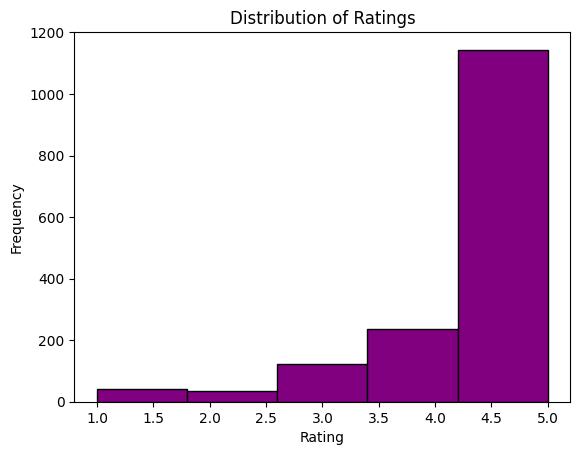

In [25]:
plt.hist(df['rating'], bins= 5, edgecolor='black', color="purple")
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [26]:
df.iloc[100]

id                                           AV00lzP7GV-KLJ3ac0uk
product_id                                             B01LW1MS9C
categories                                         Amazon Devices
name            Amazon Echo Dot Case (fits Echo Dot 2nd Genera...
rating                                                        5.0
reviews.text    A great looking cover for the Echo Dot. It giv...
user_id                                                 C. Morrow
price                                                       14.99
Name: 100, dtype: object

In [27]:
df["user_id"][10:20]

10          Miguel Martinez
11        Magnus Brattemark
12            Tedd Gardiner
13       Janet Matthews Jan
14    John Kat's the brains
15                   samira
16             Louis simard
17                   JanetC
18                 Shepherd
19                   Brenda
Name: user_id, dtype: object

In [28]:
df["user_id"] = (
    df["user_id"]
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
)

In [29]:
print(f'{"price mean: "} {df["price"].mean()}')
print(f'{"price max: "} {df["price"].max()}')
print(f'{"price max: "} {df["price"].mean()}')

price mean:  95.82608227848101
price max:  464.0
price max:  95.82608227848101


In [30]:
df["categories"].unique()

array(['Amazon Devices,mazon.co.uk',
       'Kindle Store,Amazon Devices,Electronics',
       'Categories,Amazon Devices,Streaming Media Players',
       'Amazon Devices',
       'Categories,Amazon Devices,Electronics Features,Streaming Media Players,Consumer Electronics,See more Amazon Fire TV Digital HD Media Streamer (Late...',
       'Amazon Devices & Accessories,Amazon Device Accessories,Power Adapters & Cables,Kindle Store,Kindle E-Reader Accessories,Kindle Paperwhite Accessories',
       'Amazon Devices,Kindle Store', 'Electronics,Amazon Devices',
       'Amazon Devices,Kindle Accessories',
       'Amazon Devices,Electronics,Kindle Store',
       'Amazon Devices,Electronics,Kindle Store,Amazon Echo',
       'Amazon Devices,Kindle Store,Kindle Accessories',
       'Amazon Devices,Kindle Store,buy a kindle',
       'Amazon Devices,Home,Smart Home & Connected Living,Smart Hubs & Wireless Routers,Smart Hubs,Home Improvement,Home Safety & Security,Alarms & Sensors,Home Security,Amazo

In [31]:
df["categories"] = df["categories"].str.lower()
df["categories"] = df["categories"].replace("&",",")
df['categories'] = df['categories'].str.replace(r'\s*,\s*', ',', regex=True)  # استاندارد کردن کاما
df['categories'] = df['categories'].str.replace(r',,+', ',', regex=True)       # کامای چندتا
df['categories'] = df['categories'].str.replace(r'^,|,$', '', regex=True)     # کاما اول و آخر
df['categories'] = df['categories'].str.strip()

In [32]:
df["categories"].unique()

array(['amazon devices,mazon.co.uk',
       'kindle store,amazon devices,electronics',
       'categories,amazon devices,streaming media players',
       'amazon devices',
       'categories,amazon devices,electronics features,streaming media players,consumer electronics,see more amazon fire tv digital hd media streamer (late...',
       'amazon devices & accessories,amazon device accessories,power adapters & cables,kindle store,kindle e-reader accessories,kindle paperwhite accessories',
       'amazon devices,kindle store', 'electronics,amazon devices',
       'amazon devices,kindle accessories',
       'amazon devices,electronics,kindle store',
       'amazon devices,electronics,kindle store,amazon echo',
       'amazon devices,kindle store,kindle accessories',
       'amazon devices,kindle store,buy a kindle',
       'amazon devices,home,smart home & connected living,smart hubs & wireless routers,smart hubs,home improvement,home safety & security,alarms & sensors,home security,amazo

In [33]:
df.head()

,id,product_id,categories,name,rating,reviews.text,user_id,price
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,5.0,I initially had trouble deciding between the p...,cristina_m,139.99
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,5.0,Allow me to preface this with a little history...,ricky,139.99
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,4.0,I am enjoying it so far. Great for reading. Ha...,tedd_gardiner,139.99
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,5.0,I bought one of the first Paperwhites and have...,dougal,139.99
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,5.0,I have to say upfront - I don't like coroporat...,miljan_david_tanic,139.99
